# Instruction to lab work # 4: "Intro to ANN Gradient Descent optimizers"

> Student name    - Volodymyr

> Student surname - Donets

> Group           - KU-31


# Tasks & conditions of the work

1. Use the article [An overview of gradient descent optimization algorithms](https://arxiv.org/pdf/1609.04747). Read it and try to understand.
2. In the code realized mini-batch gradient descend your task is only to improve it with optimizers (Consider only `Momemntum`, `Nesterov accelerated gradient`, `Adagrad`, `RMSProp`) 
3. Do NOT change the NN architecture.
4. Do NOT apply any other optimizations.
5. Do your changes in `# TODO` Section 
6. Try each of the proposed optimizers and observe final performance of your ANN after 50 training steps (be aware that for some of them you'll need to remove learning rate schedule).
7. Do your conclusions on the following questions:
   1. Why do we need to use Mini-batch Gradient Descent?
   2. Why do we need to accelerate it?
   3. Which of the proposed optimizers consume least and most memory?
   4. Which of the proposed optimizers deals with learning rate automatically?

# Code part
## Import dependencies

In [ ]:
!pip install tensorflow==2.12.0
!pip install tensorflow-datasets
!pip install tensorflow-addons

In [29]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

from matplotlib import rcParams
from matplotlib import pyplot as plt

import tensorflow_addons as tfa
from random import seed
from random import randint
from random import random

from tqdm import tqdm

seed(23)

In [4]:
print(tf.__version__)

2.12.0


## Load & prepare data

In [5]:
# now it loads data for training and data for testing, also it loads info about
# this dataset
train_data, info = tfds.load("fashion_mnist", with_info=True, split="train")
test_data = tfds.load("fashion_mnist", split="test")

In [6]:
# give names of each in the dataset
names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [7]:
rcParams["figure.figsize"] = [10, 10]
rcParams['xtick.labelbottom'] = False

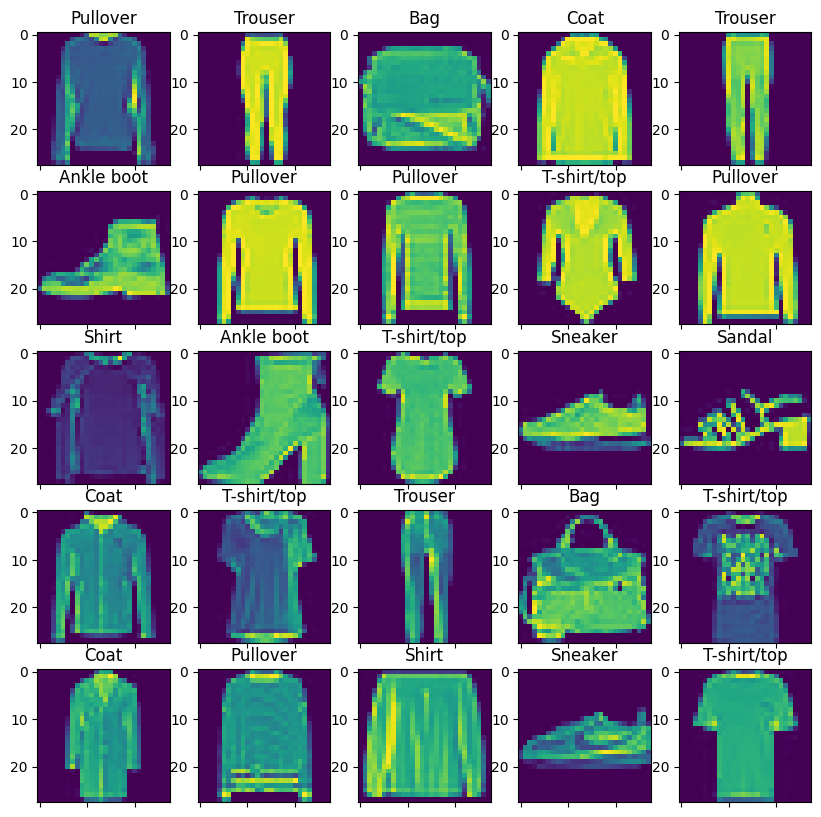

In [8]:
# finally plot it
for idx, elem in enumerate(train_data.take(25)):
    plt.subplot(5, 5, idx + 1, title=names[elem['label'].numpy()])
    plt.imshow(elem['image'][:, :, 0])

In [9]:
# this function does the simplest pre-processing, it just unzip loaded data
# in more comfortable way
def preprocessing(data):
    x = tf.reshape(data["image"], [-1])
    y = data["label"]
    return x, y


def preprocessing_with_norm(data):
    x = tf.reshape(data["image"], [-1]) / 255
    y = data["label"]
    return x, y

In [25]:
train_data_pre = train_data.map(preprocessing_with_norm)
test_data_pre = test_data.map(preprocessing_with_norm)

batch_size = 64
train_data_pre = train_data_pre.batch(batch_size)
test_data_pre = test_data_pre.batch(batch_size)

## Create model

In [26]:
# this function defines base model (!!!WARNING, in the task I can't modify it).
# then it creates model and print model summary
# Cause we have the input 28*28*1 (gray_scale) = 784 - here is an input layer

def base_model():
    inputs = tf.keras.Input(shape=(784,))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    model_ = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model_

In [53]:
model = base_model()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_9 (Dense)             (None, 64)                50240     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [47]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

@tf.function
def regularization_l1(trainable_variables, var_lambda=0.01):
    reg = 0.0
    for x in trainable_variables:
        reg = reg + tf.math.reduce_sum(tf.math.abs(x))
    return var_lambda * reg

@tf.function
def regularization_l2(trainable_variables, var_lambda=0.01):
    reg = 0.0
    for x in trainable_variables:
        reg = reg + tf.math.reduce_sum(tf.math.square(x))
    reg = tf.math.sqrt(reg)
    return var_lambda * reg

@tf.function
def regularization_l1_l2(trainable_variables, var_lambda_l1=0.01, var_lambda_l2=0.01):
    reg_l1 = regularization_l1(trainable_variables, var_lambda=var_lambda_l1)
    reg_l2 = regularization_l2(trainable_variables, var_lambda=var_lambda_l2)
    return reg_l1 + reg_l2



@tf.function
def train_step(x, y, lr=0.0005):
    with tf.GradientTape() as tape:
        pred = model(x)
        loss = loss_object(y, pred)
        # TODO 0: uncomment 32 & 33 and comment 35 to see how work regularization
        # regl = regularization_l2(model.trainable_variables)
        # gradients = tape.gradient(loss + regl, model.trainable_variables)
        # TODO main: add here your code for optimizing gradient descent
        gradients = tape.gradient(loss, model.trainable_variables)

        new_weights = []
        for w, grad in zip(model.trainable_variables, gradients):
            new_weights.append(w - lr * grad)

        for v, w in zip(model.trainable_variables, new_weights):
            v.assign(w)
    pred_nums = tf.math.argmax(pred, axis=1)
    equality = tf.math.equal(pred_nums, y)
    accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))

    return loss, accuracy

In [41]:
x_test = np.concatenate([x for x, y in test_data_pre], axis=0)
y_test = np.concatenate([y for x, y in test_data_pre], axis=0)

In [42]:
def calc_acc():
    pred = model.predict(x_test)
    acc = np.sum(np.argmax(pred, axis=-1) == y_test) / len(y_test)
    return acc

In [43]:
def schedule_lr(epoch_count, epoch):
    if epoch < epoch_count / 5:
        return 0.001
    elif epoch < 2 * epoch_count / 5:
        return 0.0009
    elif epoch < 3 * epoch_count / 5:
        return 0.0007
    elif epoch < 4 * epoch_count / 5:
        return 0.0008
    else:
        return 0.0005

In [54]:
total_loss_acc_array = []

epoch_count = 50
count_batches = len(train_data_pre)
for epoch in range(epoch_count):
    # lr = schedule_lr(epoch_count, epoch)
    lr = 0.00008
    total_loss = 0.0
    total_accuracy = 0.0
    print("\nEpoch {}:".format(str(epoch + 1) + "/" + str(epoch_count)))
    for step, (x, y) in enumerate(tqdm(train_data_pre)):
        training_result = train_step(x, y, lr=lr)
        total_loss = total_loss + training_result[0].numpy()
        total_accuracy = total_accuracy + training_result[1].numpy()
    total_loss = total_loss / count_batches
    total_accuracy = total_accuracy / count_batches
    total_loss_acc_array.append([epoch + 1, total_loss, total_accuracy])
    print("loss =", total_loss, " acc =", total_accuracy)


Epoch 1/50:


100%|██████████| 938/938 [00:01<00:00, 720.95it/s]


loss = 2.3576238114696575  acc = 0.06866337953091685

Epoch 2/50:


100%|██████████| 938/938 [00:01<00:00, 890.47it/s]


loss = 2.253143789925809  acc = 0.15498400852878466

Epoch 3/50:


100%|██████████| 938/938 [00:01<00:00, 895.93it/s]


loss = 2.1855343412488764  acc = 0.2269289712153518

Epoch 4/50:


100%|██████████| 938/938 [00:01<00:00, 887.92it/s]


loss = 2.1298802831788053  acc = 0.28504797441364604

Epoch 5/50:


100%|██████████| 938/938 [00:01<00:00, 873.40it/s]


loss = 2.0779513176570314  acc = 0.3275086620469083

Epoch 6/50:


100%|██████████| 938/938 [00:01<00:00, 880.52it/s]


loss = 2.026801586151123  acc = 0.3644056503198294

Epoch 7/50:


100%|██████████| 938/938 [00:01<00:00, 872.01it/s]


loss = 1.9750481503350394  acc = 0.39715485074626866

Epoch 8/50:


100%|██████████| 938/938 [00:01<00:00, 893.14it/s]


loss = 1.9221474302094628  acc = 0.4264059168443497

Epoch 9/50:


100%|██████████| 938/938 [00:01<00:00, 892.47it/s]


loss = 1.8683117476861868  acc = 0.4557069562899787

Epoch 10/50:


100%|██████████| 938/938 [00:01<00:00, 887.43it/s]


loss = 1.8137356752017413  acc = 0.4886060767590618

Epoch 11/50:


100%|██████████| 938/938 [00:01<00:00, 884.11it/s]


loss = 1.7587194689301286  acc = 0.5253031716417911

Epoch 12/50:


100%|██████████| 938/938 [00:01<00:00, 893.35it/s]


loss = 1.7037875273588623  acc = 0.5576692430703625

Epoch 13/50:


100%|██████████| 938/938 [00:01<00:00, 856.01it/s]


loss = 1.6496783356422555  acc = 0.581972947761194

Epoch 14/50:


100%|██████████| 938/938 [00:01<00:00, 851.88it/s]


loss = 1.597033381589186  acc = 0.5992470682302772

Epoch 15/50:


100%|██████████| 938/938 [00:01<00:00, 886.47it/s]


loss = 1.5462722633439085  acc = 0.6102745202558635

Epoch 16/50:


100%|██████████| 938/938 [00:01<00:00, 888.63it/s]


loss = 1.4976202937077359  acc = 0.6180703624733476

Epoch 17/50:


100%|██████████| 938/938 [00:01<00:00, 886.04it/s]


loss = 1.4511832742294524  acc = 0.6227012260127932

Epoch 18/50:


100%|██████████| 938/938 [00:01<00:00, 894.38it/s]


loss = 1.4070707141463437  acc = 0.6271821695095949

Epoch 19/50:


100%|██████████| 938/938 [00:01<00:00, 882.60it/s]


loss = 1.365288549903105  acc = 0.6306136727078892

Epoch 20/50:


100%|██████████| 938/938 [00:01<00:00, 885.14it/s]


loss = 1.325773705043264  acc = 0.6335787579957356

Epoch 21/50:


100%|██████████| 938/938 [00:01<00:00, 888.35it/s]


loss = 1.288562539289755  acc = 0.6357942430703625

Epoch 22/50:


100%|██████████| 938/938 [00:01<00:00, 839.68it/s]


loss = 1.2537173477571402  acc = 0.6379097814498934

Epoch 23/50:


100%|██████████| 938/938 [00:01<00:00, 857.35it/s]


loss = 1.2212889608162552  acc = 0.6401419243070362

Epoch 24/50:


100%|██████████| 938/938 [00:01<00:00, 863.22it/s]


loss = 1.191238668681716  acc = 0.642757196162047

Epoch 25/50:


100%|██████████| 938/938 [00:01<00:00, 858.51it/s]


loss = 1.1634366367417357  acc = 0.6452058901918977

Epoch 26/50:


100%|██████████| 938/938 [00:01<00:00, 874.35it/s]


loss = 1.137744372714557  acc = 0.6472381396588486

Epoch 27/50:


100%|██████████| 938/938 [00:01<00:00, 880.10it/s]


loss = 1.1139623072228706  acc = 0.6496368603411514

Epoch 28/50:


100%|██████████| 938/938 [00:01<00:00, 841.70it/s]


loss = 1.0918853666736628  acc = 0.6520522388059702

Epoch 29/50:


100%|██████████| 938/938 [00:01<00:00, 885.13it/s]


loss = 1.071346035517101  acc = 0.6548174307036247

Epoch 30/50:


100%|██████████| 938/938 [00:01<00:00, 870.39it/s]


loss = 1.0522040821341818  acc = 0.6575826226012793

Epoch 31/50:


100%|██████████| 938/938 [00:01<00:00, 867.25it/s]


loss = 1.0344150569011916  acc = 0.6600146588486141

Epoch 32/50:


100%|██████████| 938/938 [00:01<00:00, 878.15it/s]


loss = 1.0178908543037708  acc = 0.6623800639658849

Epoch 33/50:


100%|██████████| 938/938 [00:01<00:00, 781.00it/s]


loss = 1.002515630744922  acc = 0.6651619136460555

Epoch 34/50:


100%|██████████| 938/938 [00:01<00:00, 850.97it/s]


loss = 0.9881890480325166  acc = 0.6676772388059702

Epoch 35/50:


100%|██████████| 938/938 [00:01<00:00, 868.59it/s]


loss = 0.9747937784266116  acc = 0.669876066098081

Epoch 36/50:


100%|██████████| 938/938 [00:01<00:00, 872.21it/s]


loss = 0.9622369843251162  acc = 0.6725579690831557

Epoch 37/50:


100%|██████████| 938/938 [00:01<00:00, 886.55it/s]


loss = 0.9504516326796526  acc = 0.6748900586353944

Epoch 38/50:


100%|██████████| 938/938 [00:01<00:00, 891.63it/s]


loss = 0.9393650802976287  acc = 0.6773054371002132

Epoch 39/50:


100%|██████████| 938/938 [00:01<00:00, 886.50it/s]


loss = 0.9289051486230863  acc = 0.6792710554371002

Epoch 40/50:


100%|██████████| 938/938 [00:01<00:00, 845.54it/s]


loss = 0.919005056497639  acc = 0.6810867537313433

Epoch 41/50:


100%|██████████| 938/938 [00:01<00:00, 894.01it/s]


loss = 0.9096183506156336  acc = 0.6832689232409381

Epoch 42/50:


100%|██████████| 938/938 [00:01<00:00, 895.26it/s]


loss = 0.9007068672286931  acc = 0.6854677505330491

Epoch 43/50:


100%|██████████| 938/938 [00:01<00:00, 884.66it/s]


loss = 0.8922280060457014  acc = 0.6874167110874201

Epoch 44/50:


100%|██████████| 938/938 [00:01<00:00, 892.42it/s]


loss = 0.8841466291753977  acc = 0.6895489072494669

Epoch 45/50:


100%|██████████| 938/938 [00:01<00:00, 890.11it/s]


loss = 0.8764268066456069  acc = 0.6920475746268657

Epoch 46/50:


100%|██████████| 938/938 [00:01<00:00, 890.86it/s]


loss = 0.8690437091820276  acc = 0.6942297441364605

Epoch 47/50:


100%|██████████| 938/938 [00:01<00:00, 890.79it/s]


loss = 0.8619706727929716  acc = 0.6965118603411514

Epoch 48/50:


100%|██████████| 938/938 [00:01<00:00, 892.34it/s]


loss = 0.8551840404076363  acc = 0.6984608208955224

Epoch 49/50:


100%|██████████| 938/938 [00:01<00:00, 876.28it/s]


loss = 0.8486626874536339  acc = 0.7005930170575693

Epoch 50/50:


100%|██████████| 938/938 [00:01<00:00, 883.57it/s]

loss = 0.8423862666971902  acc = 0.7024586886993603


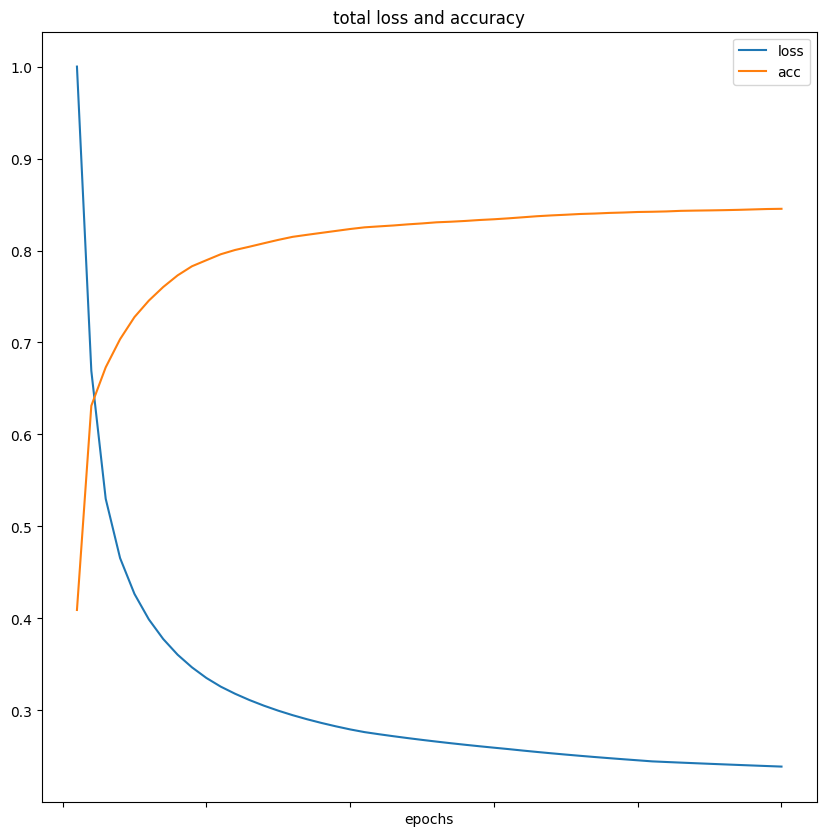

In [49]:
epoch_array = []
loss_array = []
acc_array = []
for inx in range(len(total_loss_acc_array)):
    epoch_array.append(total_loss_acc_array[inx][0])
    loss_array.append(total_loss_acc_array[inx][1])
    acc_array.append(total_loss_acc_array[inx][2])

max_loss = max(loss_array)
loss_array = loss_array / max_loss

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, acc_array, label="acc")
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

In [55]:
print("\n\nShow last accuracity")
print("Test acc: ", calc_acc())



Show last accuracity
313/313 [==============================] - 0s 804us/step
Test acc:  0.6905


In [56]:
rcParams["figure.figsize"] = [10, 10]
rcParams['xtick.labelbottom'] = False

313/313 [==============================] - 0s 741us/step


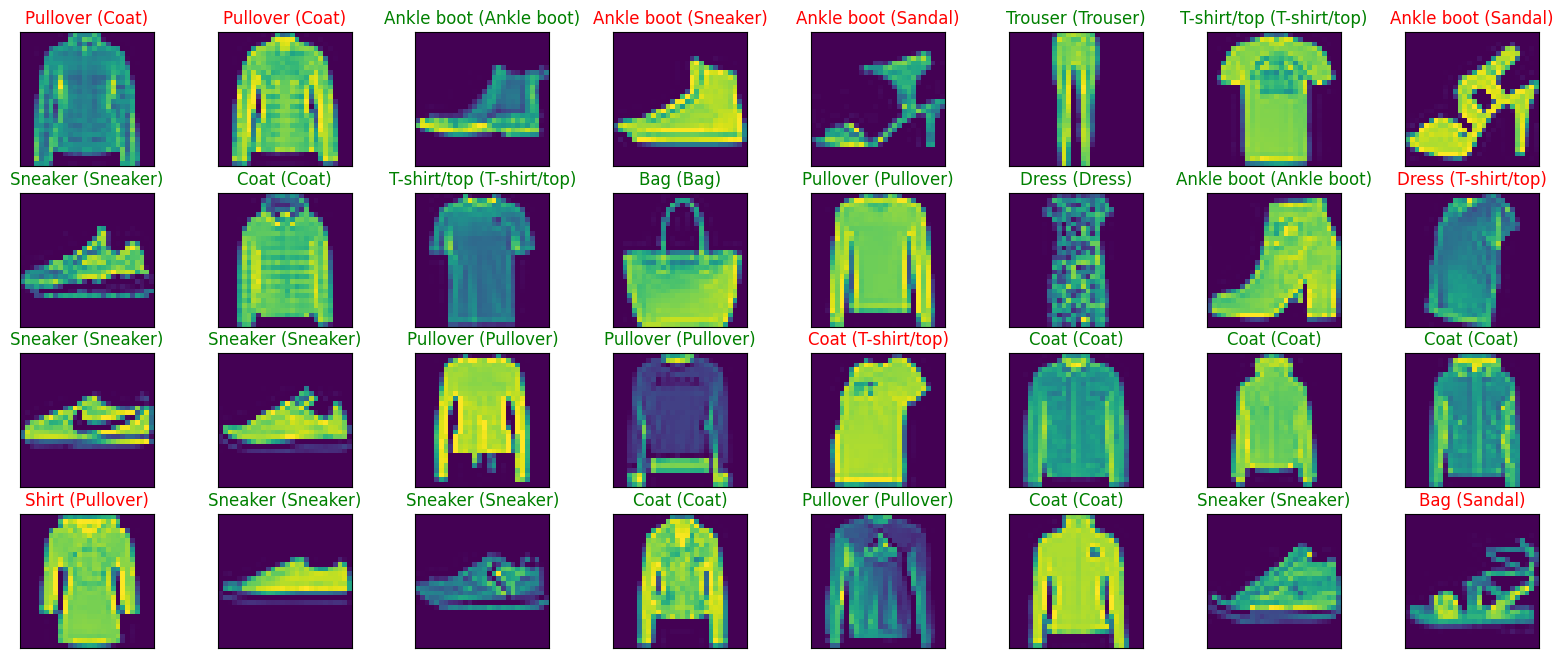

In [57]:
test_pred = model.predict(x_test)
fig = plt.figure(figsize=(20, 8))

for idx, elem in enumerate(test_data.take(32)):
    ax = fig.add_subplot(4, 8, idx + 1, xticks=[], yticks=[])
    ax.imshow(elem['image'][:, :, 0])
    pred_idx = np.argmax(test_pred[idx])
    true_idx = y_test[idx]
    ax.set_title("{} ({})".format(names[pred_idx], names[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
plt.show()

# Conclusions on work